  <style>
    .container {
      display: flex;
      justify-content: space-between;
      align-items: center;
    }

    .text {
      width: 95%;
       text-align: center;
    }

    .image {
      width: 5%;
      text-align: center; 
    }

    
    .image img {
      max-width: 100%;
      height: auto;
    }
  </style> 
  
  <div class="container">
    <div class="image">
      <img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Logo_KIT.svg/1200px-Logo_KIT.svg.png" width=100 height=50/>
    </div>
        <div class="text">
      <h1> Medical Image Processing and Navigation 2024/25</h1>
    </div>
  </div>

---

<center>
<h2>Medical Image Processing</h2> 
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSMyuSDBLJILqpD1O1Z5XE8EKC5VJ0eoHB3S_0GyLFG_umpP0U6NBi_mTQQrW2xyAClYag&usqp=CAU"/>


---

<center>
Lecturer: <b><i>Ciro Benito Raggio</i></b> 
<br/>
<a><href>https://www.ibt.kit.edu/english/Raggio_C.php</href></a>

# Basic image manipulation with SimpleITK

## Crop

In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

ct_path='assets/data/tmp-5054-4218953600.nii'
ct_label_path='assets/data/tmp-9191-4566520300.nii'

# CT
ct_sitk  = sitk.ReadImage(ct_path, sitk.sitkFloat32) # Reading CT
ct_array = sitk.GetArrayFromImage(ct_sitk) # Converting sitk_metadata to image array

# Label
label_sitk = sitk.ReadImage(ct_label_path,sitk.sitkInt32) # Reading label
label_array = sitk.GetArrayFromImage(label_sitk) 

print(f'Original CT shape {ct_array.shape}, Original CT Label shape {label_array.shape}')

Original CT shape (147, 512, 512), Original CT Label shape (147, 512, 512)


Shape before crop (147, 512, 512)
Shape after crop (147, 512, 472)


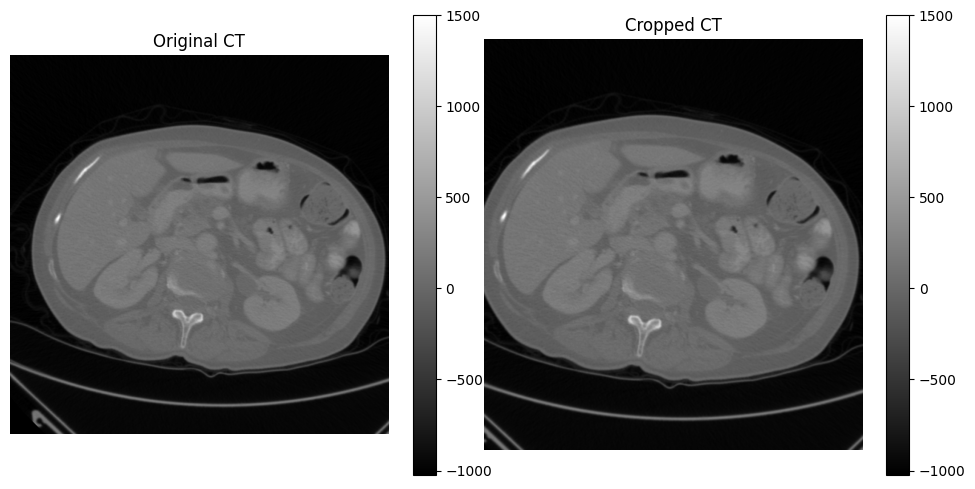

In [2]:
slice_number=100
# Cropping takes the orientation of the pixels for the reference of lower & upper boundaries vectors
# Pixel orientation = RPS = (left-to-Right, anterior-to-Posterior, inferior-to-Superior)

# crop 40 from inferior to superior, crop 50 from superior to inferior
#                                     X,Y,Z 
cropped_ct_sitk = sitk.Crop(ct_sitk, (40,0,0)) 
cropped_ct_array = sitk.GetArrayFromImage(cropped_ct_sitk)

print(f'Shape before crop {sitk.GetArrayFromImage(ct_sitk).shape}\nShape after crop {cropped_ct_array.shape}')

f, axarr = plt.subplots(1, 2, figsize=(10,5))

img = axarr[0].imshow(np.squeeze(ct_array[slice_number, :, :]), cmap='gray',origin='lower')
axarr[0].axis('off')
axarr[0].set_title('Original CT')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(cropped_ct_array[slice_number, :, :]), cmap='gray', origin='lower')
axarr[1].axis('off')
axarr[1].set_title('Cropped CT')
f.colorbar(img, ax=axarr[1])
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

## Padding
Padding is used to create space around an element's content, inside of any defined borders

Current constant: -1024
Shape before pad (147, 512, 512)
Shape after pad (147, 677, 592)


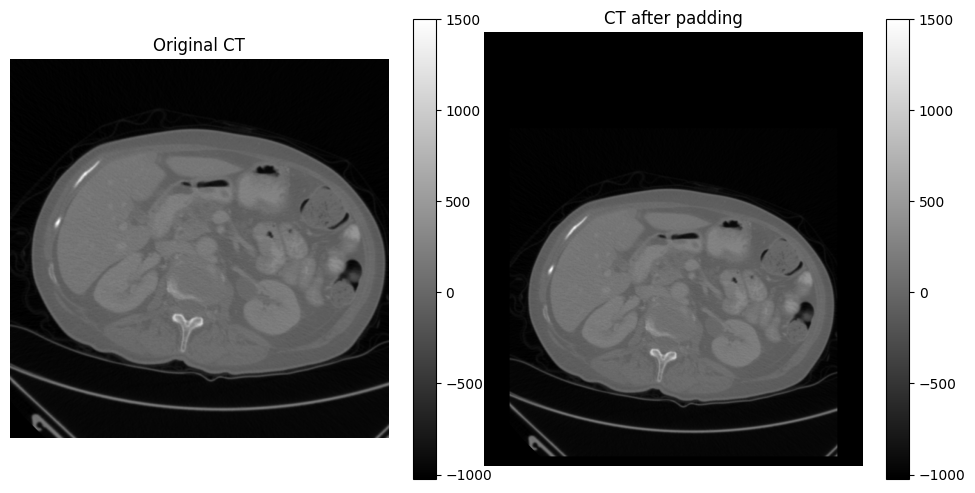

In [3]:
# Find the desired intensity for the edges, equivalent to the minimum value present in the CT
constant = int(sitk.GetArrayFromImage(ct_sitk).min())
print(f"Current constant: {constant}")

# Padding (as Cropping) takes the orientation of the pixels for the reference of lower & upper boundaries vectors
# Pixel orientation = RPS = (left-to-Right, anterior-to-Posterior, inferior-to-Superior)

# pad 40 from left to right, pad 15 from anterior to posterior, 
# pad 40x from right to left, pad 8 from posterior to anterior. 
transformed = sitk.ConstantPad(ct_sitk,(40,15,0),(40,150,0),constant)
pad_ct_array = sitk.GetArrayFromImage(transformed)

print(f'Shape before pad {sitk.GetArrayFromImage(ct_sitk).shape}\nShape after pad {pad_ct_array.shape}')

f, axarr = plt.subplots(1, 2, figsize=(10,5))

img = axarr[0].imshow(np.squeeze(ct_array[100, :, :]), cmap='gray',origin='lower')
axarr[0].axis('off')
axarr[0].set_title('Original CT')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(pad_ct_array[slice_number, :, :]), cmap='gray', origin='lower')
axarr[1].axis('off')
axarr[1].set_title('CT after padding')
f.colorbar(img, ax=axarr[1])
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

## Normalization and Masking

## Normalization
$$
X_{new} = \frac{X - X_{min}}{X_{max} - X_{min}}


Original ct min -1024.0 max 2639.0
Normalized ct min 0.0 max 1.0


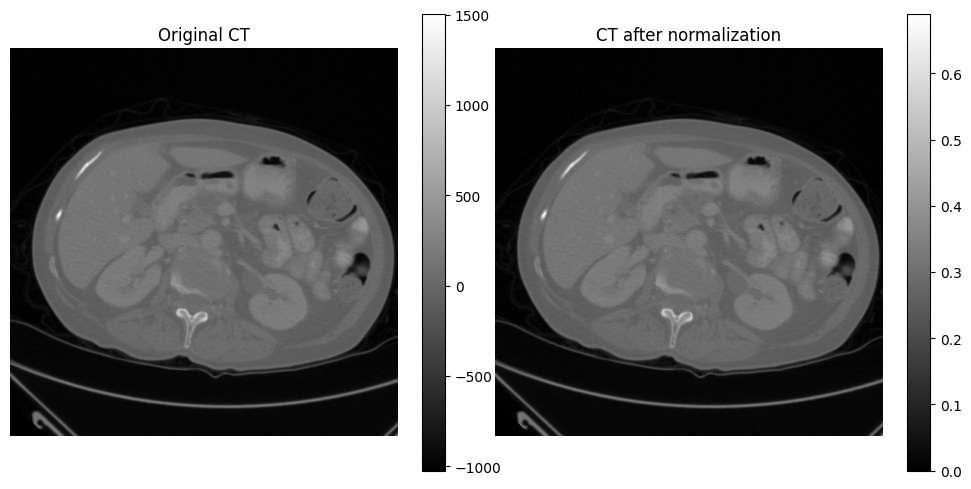

In [4]:
normalized_ct = (ct_array-np.min(ct_array))/(np.max(ct_array) - np.min(ct_array))

print(f"Original ct min {np.min(ct_array)} max {np.max(ct_array)}")
print(f"Normalized ct min {np.min(normalized_ct)} max {np.max(normalized_ct)}")

f, axarr = plt.subplots(1, 2, figsize=(10,5))

img = axarr[0].imshow(np.squeeze(ct_array[slice_number, :, :]), cmap='gray', origin='lower')
axarr[0].axis('off')
axarr[0].set_title('Original CT')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(normalized_ct[slice_number, :, :]), cmap='gray', origin='lower')
axarr[1].axis('off')
axarr[1].set_title('CT after normalization')
f.colorbar(img, ax=axarr[1])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

⚠️ In this case, however, let's remember that the CT follows a very precise scale (HU) so normalizing the values ​​between 0 and 1 is not always a good choice. ⚠️

## Masking
The most basic way is to use a fixed threshold to mask parts of the CT

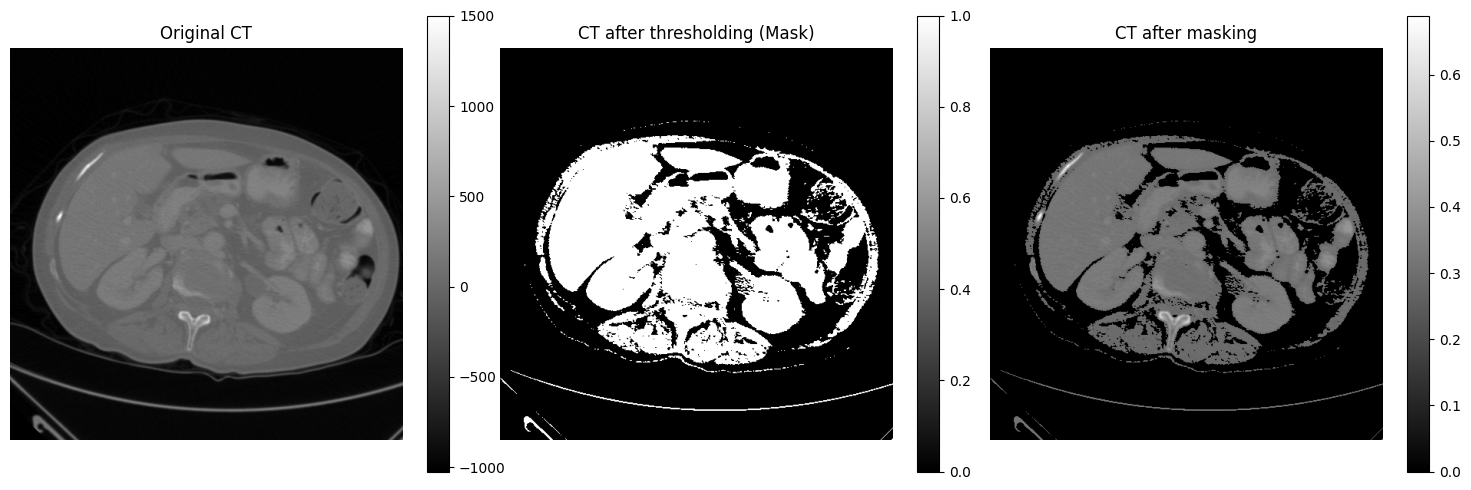

In [5]:
mask = ct_array >= 0

mask_sitk = sitk.GetImageFromArray(mask.astype(float))
ct_mask_array = sitk.GetArrayFromImage(mask_sitk)

masked_ct = normalized_ct * ct_mask_array

f, axarr = plt.subplots(1, 3, figsize=(15,5))

img = axarr[0].imshow(np.squeeze(ct_array[slice_number, :, :]), cmap='gray',origin='lower')
axarr[0].axis('off')
axarr[0].set_title('Original CT')
f.colorbar(img, ax=axarr[0])

img = axarr[1].imshow(np.squeeze(ct_mask_array[slice_number, :, :]), cmap='gray', origin='lower')
axarr[1].axis('off')
axarr[1].set_title('CT after thresholding (Mask)')
f.colorbar(img, ax=axarr[1])


img = axarr[2].imshow(np.squeeze(masked_ct[slice_number, :, :]), cmap='gray', origin='lower')
axarr[2].axis('off')
axarr[2].set_title('CT after masking')
f.colorbar(img, ax=axarr[2])

plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)

# Exercise 📖 

## Write a general function to apply pre-processing, letting the user choose which part of the pipeline to apply and which parameters to use.

In [ ]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np

def preprocessVolume(image: sitk.Image, 
                     pipelineInstructions: dict = {
                        "crop": {
                           "enable": False,
                           "axis": (0, 0, 0)  # Crop from each side (x, y, z)
                           },
                        "pad": {
                           "enable": False,
                           "mode": "constant",
                           "const": 0,
                           "lower_bound": [0, 0, 0], 
                           "upper_bound": [0, 0, 0]
                           },
                        "normalize": {
                           "enable": False,
                           "lower_value": 0,
                           "upper_value": 1
                           },   
                        "mask": {
                           "enable": False,
                           "threshold": 0
                           },
                     }
                  ) -> sitk.Image:
    # Perform cropping if enabled
    if pipelineInstructions.get("crop",{}).get("enable", False):
        crop_axis = pipelineInstructions["crop"]["axis"]
        # Crop 'crop_axis' pixels from each side for each dimension
   
        processed_image = sitk.Crop(image, crop_axis, crop_axis)
        print(f'Shape before cropping: {sitk.GetArrayFromImage(image).shape}')
        print(f'Shape after cropping: {sitk.GetArrayFromImage(processed_image).shape}')
    
    
    

   # Perform padding if enabled
    if pipelineInstructions.get("pad", {}).get("enable", False):
         pad_mode = pipelineInstructions["pad"].get("mode", "constant")
         pad_const = pipelineInstructions["pad"].get("const", 0)
         lower_bound = pipelineInstructions["pad"].get("lower_bound", [0,0,0])
         upper_bound = pipelineInstructions["pad"].get("upper_bound", [0,0,0])

         print(f'Shape before pad: {sitk.GetArrayFromImage(image).shape}')
         # Apply padding
         if pad_mode == "constant":
            processed_image = sitk.ConstantPad(image, lower_bound, upper_bound, pad_const)
         print(f'Shape after pad: {sitk.GetArrayFromImage(processed_image).shape}')

    # Perform normalizing if enabled
    if pipelineInstructions.get("normalize", {}).get("enable", False):
         lower_value = pipelineInstructions["normalize"].get("lower_value", 0)
         upper_value = pipelineInstructions["normalize"].get("upper_value", 1)
         processed_image = sitk.RescaleIntensity(image, lower_value, upper_value)
         normalized_image = processed_image

    #Perform masking if enabled
    if pipelineInstructions.get("mask", {}).get("enable", False):
        mask_threshold = pipelineInstructions["mask"].get("threshold", 0)
        #mask_sitk = sitk.BinaryThreshold(image, lowerThreshold=0, upperThreshold=float('inf'), insideValue=1, outsideValue=0)
        mask = sitk.Greater(image, mask_threshold)

        mask_array = sitk.GetArrayFromImage(mask)
        print("Maske nach Anwendung von sitk.Greater:")
        print(mask_array)

        #mask = sitk.Cast(mask, image.GetPixelID())
        processed_image = mask

        #since the test only test wheter there are only ones in the result or not I declared the mask as the result. to complete the
        #masking the original image has to be multiplied with the mask 
    

    return processed_image
   

## To complete the exercise, you will need to pass each of the unit tests.

In [70]:
import unittest
import SimpleITK as sitk

class TestPreprocessVolume(unittest.TestCase):
    
    def setUp(self):
        self.image = sitk.ReadImage('assets/data/tmp-5054-4218953600.nii', sitk.sitkFloat32)

    def test_crop_enabled(self):
        pipelineInstructions = {
            "crop": {"enable": True, "axis": (4, 4, 4)},
            "pad": {"enable": False},
            "normalize": {"enable": False},
            "mask": {"enable": False}
        }
        result = preprocessVolume(self.image, pipelineInstructions)
        self.assertEqual(result.GetSize(), (504, 504, 139))

    def test_pad_enabled(self):
        pipelineInstructions = {
            "crop": {"enable": False},
            "pad": {"enable": True, "mode": "constant", "const": -1000, "lower_bound": [1, 1, 1], "upper_bound": [1, 1, 1]},
            "normalize": {"enable": False},
            "mask": {"enable": False}
        }
        result = preprocessVolume(self.image, pipelineInstructions)
        self.assertEqual(result.GetSize(), (514, 514, 149)) 
        self.assertEqual(sitk.GetArrayFromImage(result)[0, 0, 0], -1000) # padding should be -1000
        
    def test_normalize_enabled(self):
        lower = 0
        upper = 1
        pipelineInstructions = {
            "crop": {"enable": False},
            "pad": {"enable": False},
            "normalize": {"enable": True, "lower_value": lower, "upper_value": upper},
            "mask": {"enable": False}
        }
        result = preprocessVolume(self.image, pipelineInstructions)
        array = sitk.GetArrayFromImage(result)
        self.assertAlmostEqual(np.min(array), lower)
        self.assertAlmostEqual(np.max(array), upper)

    def test_mask_enabled(self):
        pipelineInstructions = {
            "crop": {"enable": False},
            "pad": {"enable": False},
            "normalize": {"enable": False},
            "mask": {"enable": True, "threshold": -2000}
        }
        result = preprocessVolume(self.image, pipelineInstructions)
        array = sitk.GetArrayFromImage(result)
        print("Unique values in array:", np.unique(array))
        self.assertTrue((array == 1.0).all())  # All values ​​should be 1 as -2000 is greater than the lowest value in the CT
    
unittest.main(argv=[''], exit=False)

.

Shape before cropping: (147, 512, 512)
Shape after cropping: (139, 504, 504)
Maske nach Anwendung von sitk.Greater:
[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]
Unique values in array: [1]


..

Shape before pad: (147, 512, 512)
Shape after pad: (149, 514, 514)


.
----------------------------------------------------------------------
Ran 4 tests in 3.483s

OK


# References
[fitushar - Medical Imaging Preprocessing](https://github.com/fitushar/3D-Medical-Imaging-Preprocessing-All-you-need/blob/master/Code/3DMedical-Imaging-Preprocessing-All-you-need.ipynb)

[Angeluz-07 - Common operations](https://github.com/Angeluz-07/MRI-preprocessing-techniques/blob/main/notebooks/02_common_operations.ipynb)